# 필요한 라이브러리 import

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)

# 데이터로드

In [169]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 공격수 EDA

In [170]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 데이터 확인 및 제거

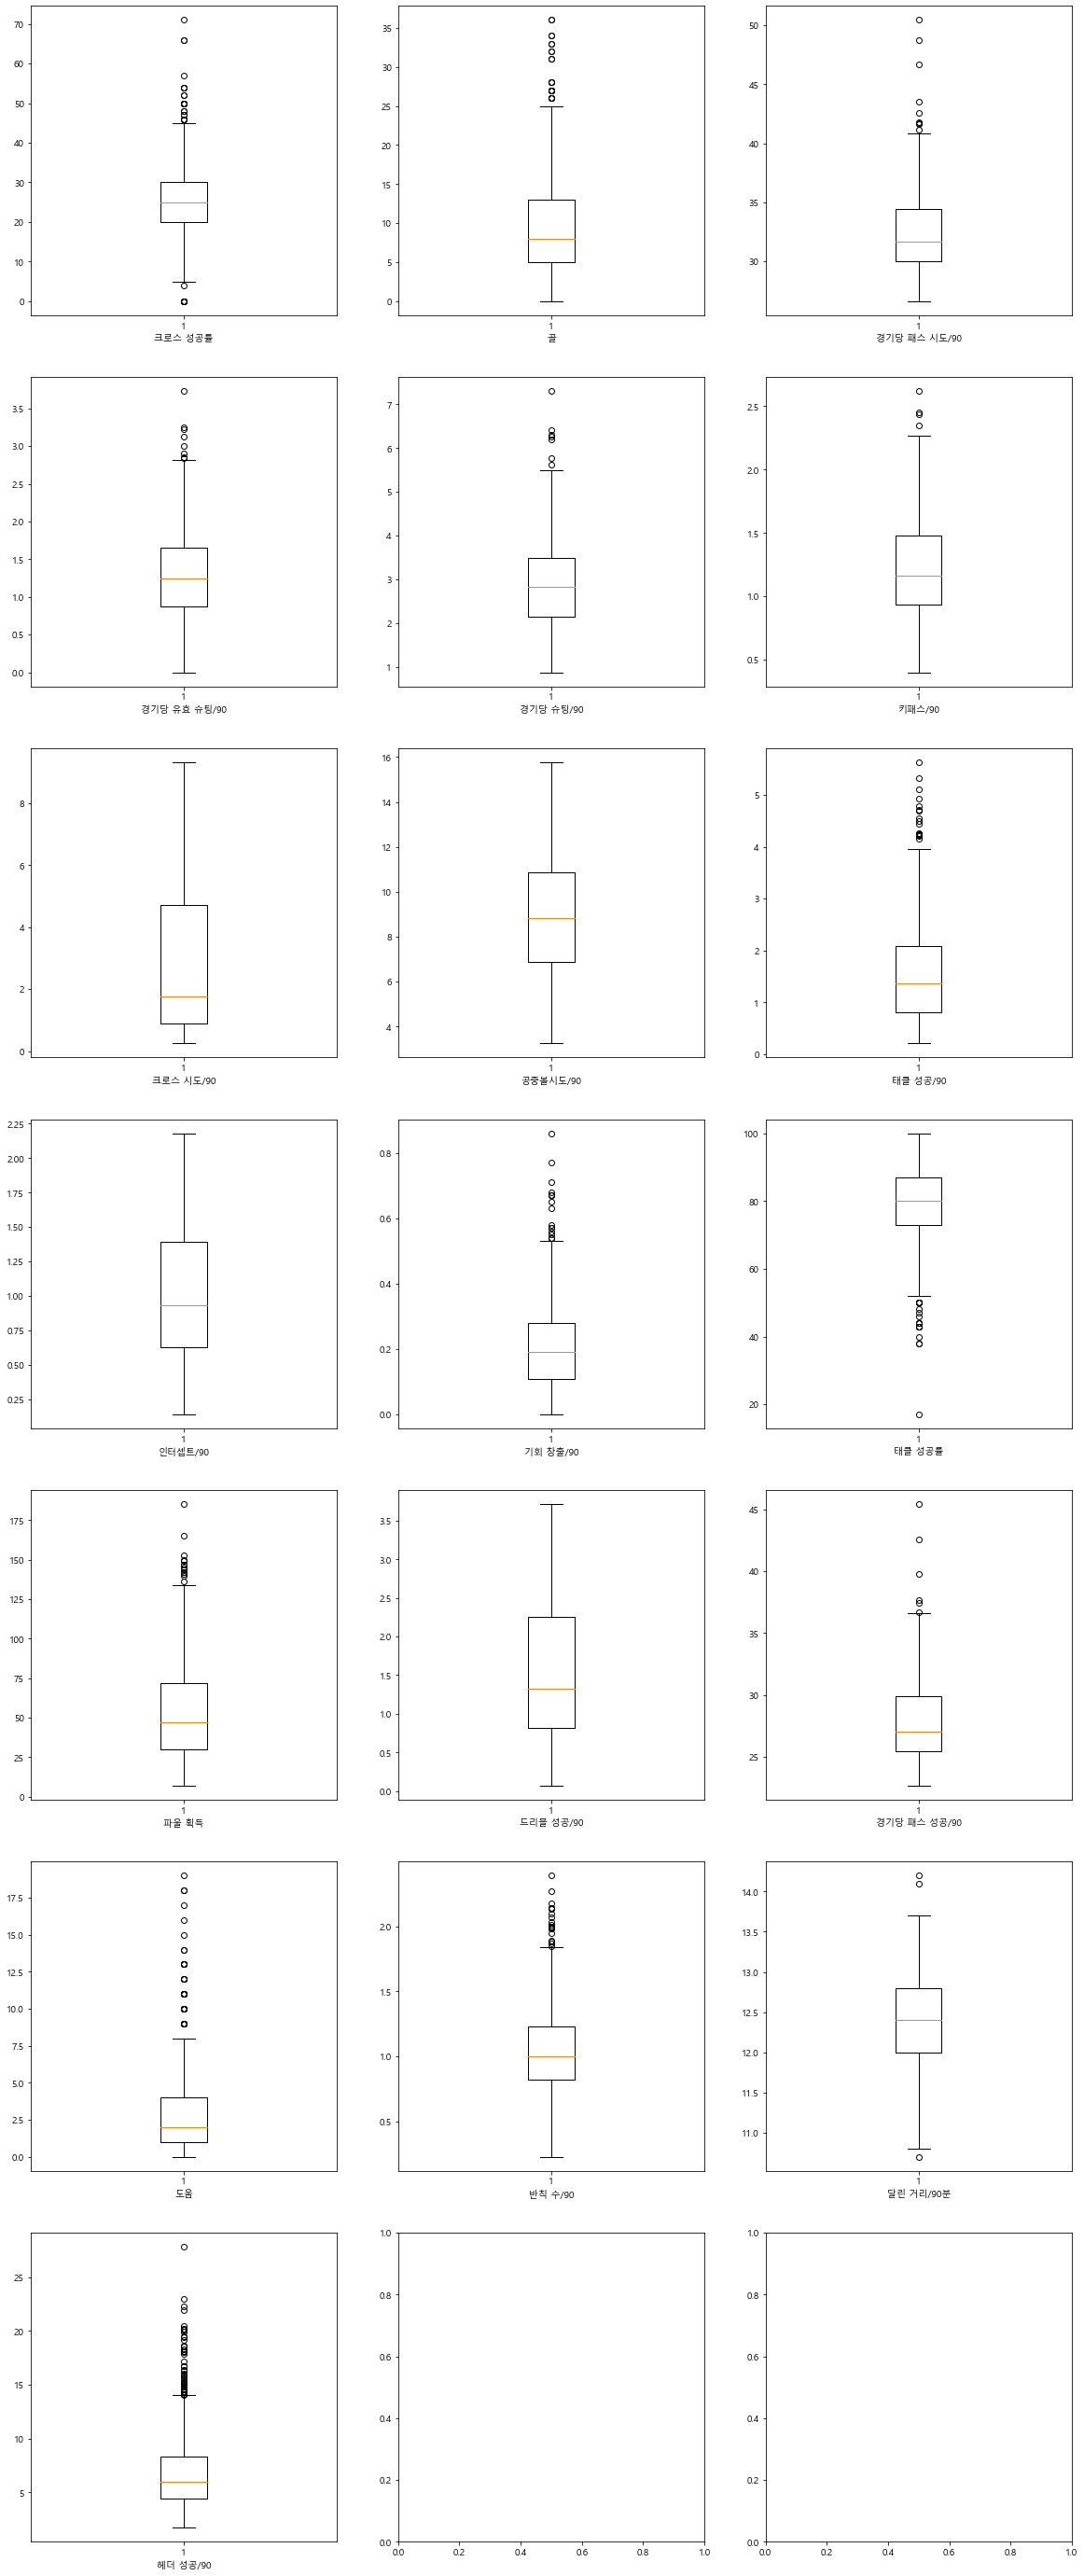

In [171]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

In [172]:
# 제거해야될 인덱스 셋
index_should_be_removed = set([])

for feature in features:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            index_should_be_removed.add(i)
            
good_index = set(forward_df.index) - index_should_be_removed
forward_df = forward_df.loc[good_index,:].reset_index(drop=True)

### 데이터 정규화

In [173]:
norm_forward_df = forward_df.copy()

forward_qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal').fit(norm_forward_df.loc[:,features])
norm_forward_df.loc[:,features] = forward_qt.transform(norm_forward_df.loc[:,features])

## 선형성 검정

### 선형성 시각화

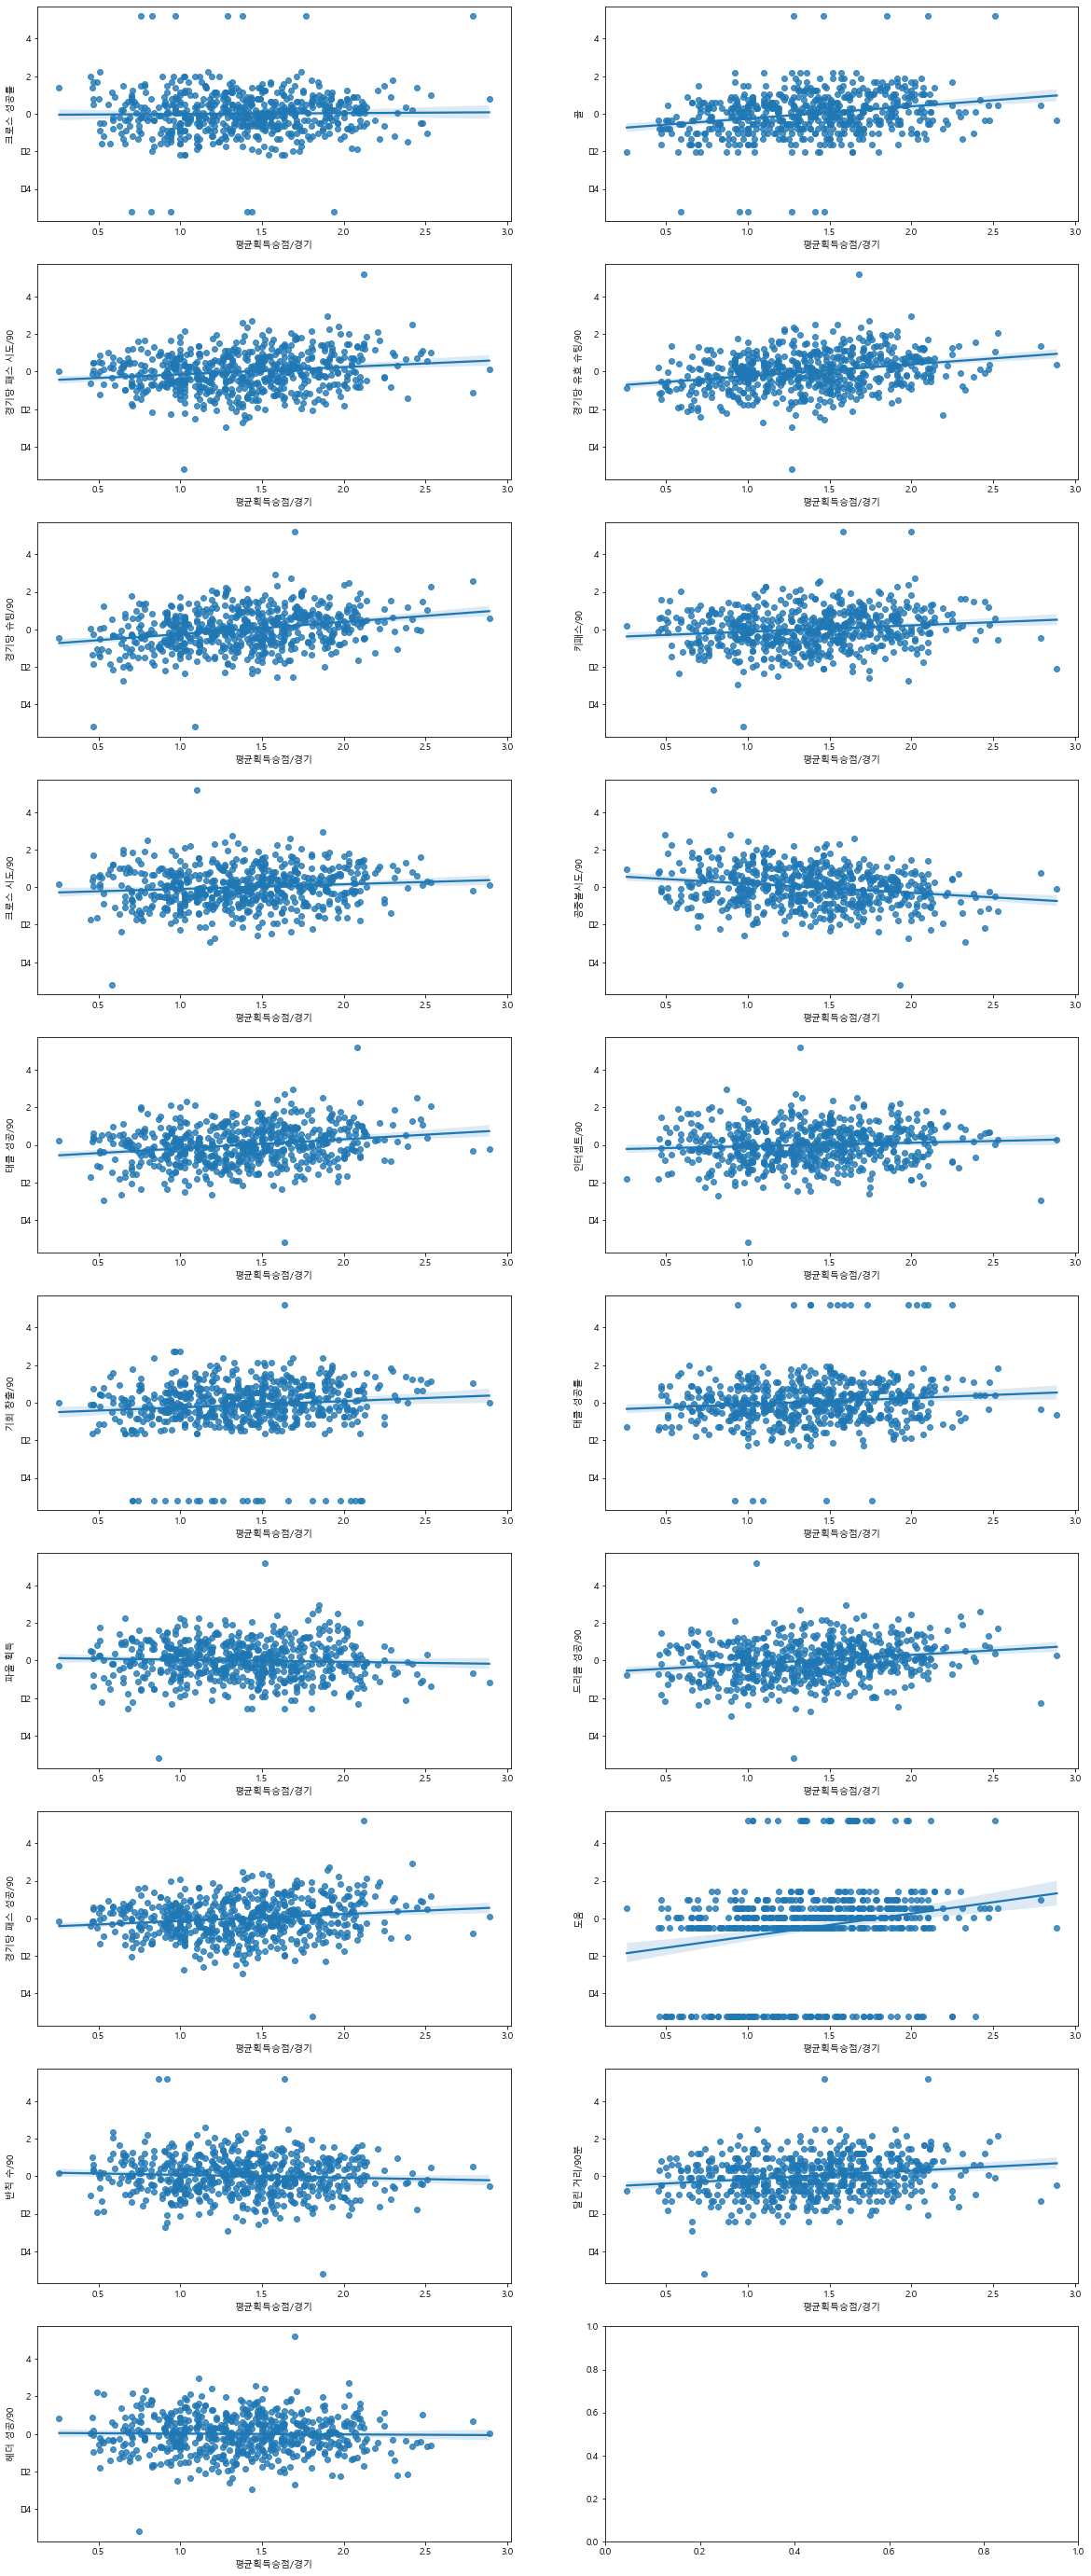

In [174]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

## 변수 정규화 및 변수 선택

### 통계치로 선형성 확인

In [175]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=norm_forward_df.loc[:,target].T.values)[0][1] for x in norm_forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('경기당 슈팅/90', 0.27433582630274383),
 ('경기당 유효 슈팅/90', 0.27017694601037434),
 ('골', 0.24872677808344862),
 ('도움', 0.2162421801526312),
 ('태클 성공/90', 0.21088853809554906),
 ('드리블 성공/90', 0.2084347973320905),
 ('달린 거리/90분', 0.1924734201349051),
 ('경기당 패스 시도/90', 0.16670061501999894),
 ('경기당 패스 성공/90', 0.15900506351469415),
 ('키패스/90', 0.1437182767540147),
 ('태클 성공률', 0.11479334543240932),
 ('크로스 시도/90', 0.10697371078266756),
 ('기회 창출/90', 0.10646795991648256),
 ('인터셉트/90', 0.0814197112172179),
 ('크로스 성공률', 0.018038783884189447),
 ('헤더 성공/90', -0.017832220834042938),
 ('파울 획득', -0.0483637422244552),
 ('반칙 수/90', -0.06305009998212686),
 ('공중볼시도/90', -0.2105390019628747)]

## 다중 공선성 확인

### VIF 확인

In [176]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(norm_forward_df.loc[:,features].values,i) for i in range(norm_forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = norm_forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,1.070644,크로스 성공률
1,1.193473,반칙 수/90
2,1.214722,기회 창출/90
3,1.267477,도움
4,1.290068,태클 성공률
5,1.869930,달린 거리/90분
6,2.110139,키패스/90
7,2.587664,골
8,2.747743,파울 획득
9,2.865283,인터셉트/90


### 상관계수 확인

In [177]:
feature_comb = list(combinations(features,2))
corr_dict_pair = {}
for a,b in feature_comb:
    spearmann = spearmanr(norm_forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)

sorted(corr_dict_pair.items(),key=lambda x : np.abs(x[1][0]),reverse=True)

[('경기당 패스 시도/90 / 경기당 패스 성공/90', (0.9746206402633606, 0.0, False)),
 ('경기당 유효 슈팅/90 / 경기당 슈팅/90',
  (0.9137517712090717, 3.1131486166476226e-239, False)),
 ('인터셉트/90 / 드리블 성공/90', (0.8251038222475654, 2.119596944598925e-152, False)),
 ('크로스 시도/90 / 태클 성공/90', (0.805806984526586, 5.12983818730482e-140, False)),
 ('크로스 시도/90 / 경기당 패스 성공/90',
  (0.7806892660812659, 7.708017369832397e-126, False)),
 ('크로스 시도/90 / 드리블 성공/90',
  (0.7737123830347324, 3.1282068538897293e-122, False)),
 ('경기당 패스 시도/90 / 크로스 시도/90',
  (0.7707578444194793, 9.651131755976062e-121, False)),
 ('크로스 시도/90 / 인터셉트/90', (0.7601904223030204, 1.358982541559384e-115, False)),
 ('공중볼시도/90 / 드리블 성공/90',
  (-0.7486311297664803, 2.935195396859056e-110, False)),
 ('인터셉트/90 / 경기당 패스 성공/90',
  (0.7383642897731735, 9.257995944751965e-106, False)),
 ('태클 성공/90 / 드리블 성공/90',
  (0.7327666965379663, 2.1430822125416246e-103, False)),
 ('경기당 패스 시도/90 / 인터셉트/90',
  (0.728970765697215, 7.956730942213414e-102, False)),
 ('골 / 파울 획득', (0.72

### 삭제할 변수, 통합해야 할 변수 고르기

1. 삭제할 변수: 달린 거리/90분,태클 성공률,인터셉트/90,태클 성공/90, 반칙 수/90, 크로스 시도/90


2. 통합해야 할 변수: (경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90)


3. 다중 공선성 해결 후: 다시 고려해 볼 변수 : 키패스/90, 드리블 성공/90 ,파울 획득, 골

In [178]:
good_features = set(features) - set(['달린거리/90분','태클 성공률','인터셉트/90',
                                     '태클 성공/90','반칙 수/90','크로스 시도/90'])
norm_forward_df.loc[:,good_features] = norm_forward_df.loc[:,good_features]

feature_comb = list(combinations(good_features,2))
corr_dict_pair = {}
for a,b in feature_comb:
    spearmann = spearmanr(norm_forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)

sorted(corr_dict_pair.items(),key=lambda x : np.abs(x[1][0]),reverse=True)

[('경기당 패스 성공/90 / 경기당 패스 시도/90', (0.9746206402633606, 0.0, False)),
 ('경기당 유효 슈팅/90 / 경기당 슈팅/90',
  (0.9137517712090717, 3.1131486166476226e-239, False)),
 ('드리블 성공/90 / 공중볼시도/90',
  (-0.7486311297664803, 2.935195396859056e-110, False)),
 ('골 / 파울 획득', (0.7261150719464741, 1.1591993018784246e-100, False)),
 ('드리블 성공/90 / 경기당 패스 성공/90',
  (0.7237324599805811, 1.0558807138178068e-99, False)),
 ('드리블 성공/90 / 경기당 패스 시도/90',
  (0.699670661399039, 1.505005731691929e-90, False)),
 ('공중볼시도/90 / 헤더 성공/90', (0.6960676500023322, 2.949893692705428e-89, False)),
 ('경기당 패스 성공/90 / 공중볼시도/90',
  (-0.6645817035173645, 9.89266141951016e-79, False)),
 ('경기당 패스 시도/90 / 공중볼시도/90',
  (-0.6593622503231628, 4.1435534511525585e-77, False)),
 ('경기당 패스 성공/90 / 달린 거리/90분',
  (0.658594141190998, 7.134136672544297e-77, False)),
 ('경기당 패스 시도/90 / 달린 거리/90분',
  (0.6526294248682482, 4.595773199784602e-75, False)),
 ('드리블 성공/90 / 달린 거리/90분', (0.6477421978697135, 1.301232542497578e-73, False)),
 ('골 / 경기당 유효 슈팅/90', (0.

In [179]:
norm_forward_df.head()

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,태클 성공률,경기당 패스 시도/90,경기당 패스 성공/90,키패스/90,태클 성공/90,드리블 성공/90,헤더 성공/90,크로스 시도/90,평균획득승점/경기,시즌
0,Branimir Hrgota,공격수,0.617253,-0.529620,1.35,2.09,0.045441,0.998665,-0.407433,-1.650470,...,-1.434025,-1.002070,-1.278740,-1.389290,-1.560609,-0.365160,-0.855829,-1.451565,0.73,2021-2022
1,Håvard Nielsen,공격수,0.617253,0.061983,1.16,1.99,-0.345367,2.272369,1.047448,0.170128,...,-0.443601,-0.233355,0.018584,-1.207220,-1.727824,-1.553668,0.439049,-0.761333,0.66,2021-2022
2,Thorgan Hazard,공격수,1.051029,0.988517,2.30,1.05,0.045441,-0.299688,-1.149350,-0.744883,...,-1.862001,0.115886,0.039241,0.070260,-0.673194,-0.794871,-0.317011,-0.402950,2.00,2021-2022
3,Donyell Malen,공격수,0.459606,0.061983,1.90,1.49,0.345367,0.958667,-0.786404,-0.394008,...,-0.958667,-1.036787,-1.445669,-0.291061,-1.666811,-0.325707,-0.995271,-1.278740,1.97,2021-2022
4,Marco Reus,공격수,0.080613,0.988517,2.14,1.52,-0.652617,-1.264834,-1.181933,1.411304,...,-0.958667,2.938797,2.579838,0.369578,0.111729,-0.022714,-1.378531,-0.124205,1.90,2021-2022


### 피쳐 엔지니어링 

목표: 피쳐 엔지니어링을 통해 선형성 만들기

1. (경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90) 합치기
    
    -> 골, 도움도 연계 해보면 어떨까?
    

2. 골,도움 연속형 변수로 만들기

    유효슈팅 당 골 전환율 * 슈팅당 유효슈팅


3. 평평한 분포 친구들 제곱해보기

#### 패스

In [180]:
norm_forward_df['패스'] = PCA(n_components=1).fit_transform(norm_forward_df.loc[:,['경기당 패스 시도/90','경기당 패스 성공/90']])
norm_forward_df['슈팅'] = PCA(n_components=1).fit_transform(norm_forward_df.loc[:,['경기당 슈팅/90','경기당 유효 슈팅/90','골']])
norm_forward_df['헤더'] = PCA(n_components=1).fit_transform(norm_forward_df.loc[:,['공중볼시도/90','헤더 성공/90']])

In [181]:
norm_forward_df=norm_forward_df.drop(columns=['경기당 패스 시도/90','경기당 패스 성공/90','경기당 슈팅/90',
                              '경기당 유효 슈팅/90','골','공중볼시도/90','헤더 성공/90'])

In [182]:
good_features = list(good_features - set(['경기당 패스 시도/90','경기당 패스 성공/90','경기당 슈팅/90',
                              '경기당 유효 슈팅/90','골','공중볼시도/90','헤더 성공/90']))

In [183]:
good_features.extend(['패스','슈팅','헤더'])

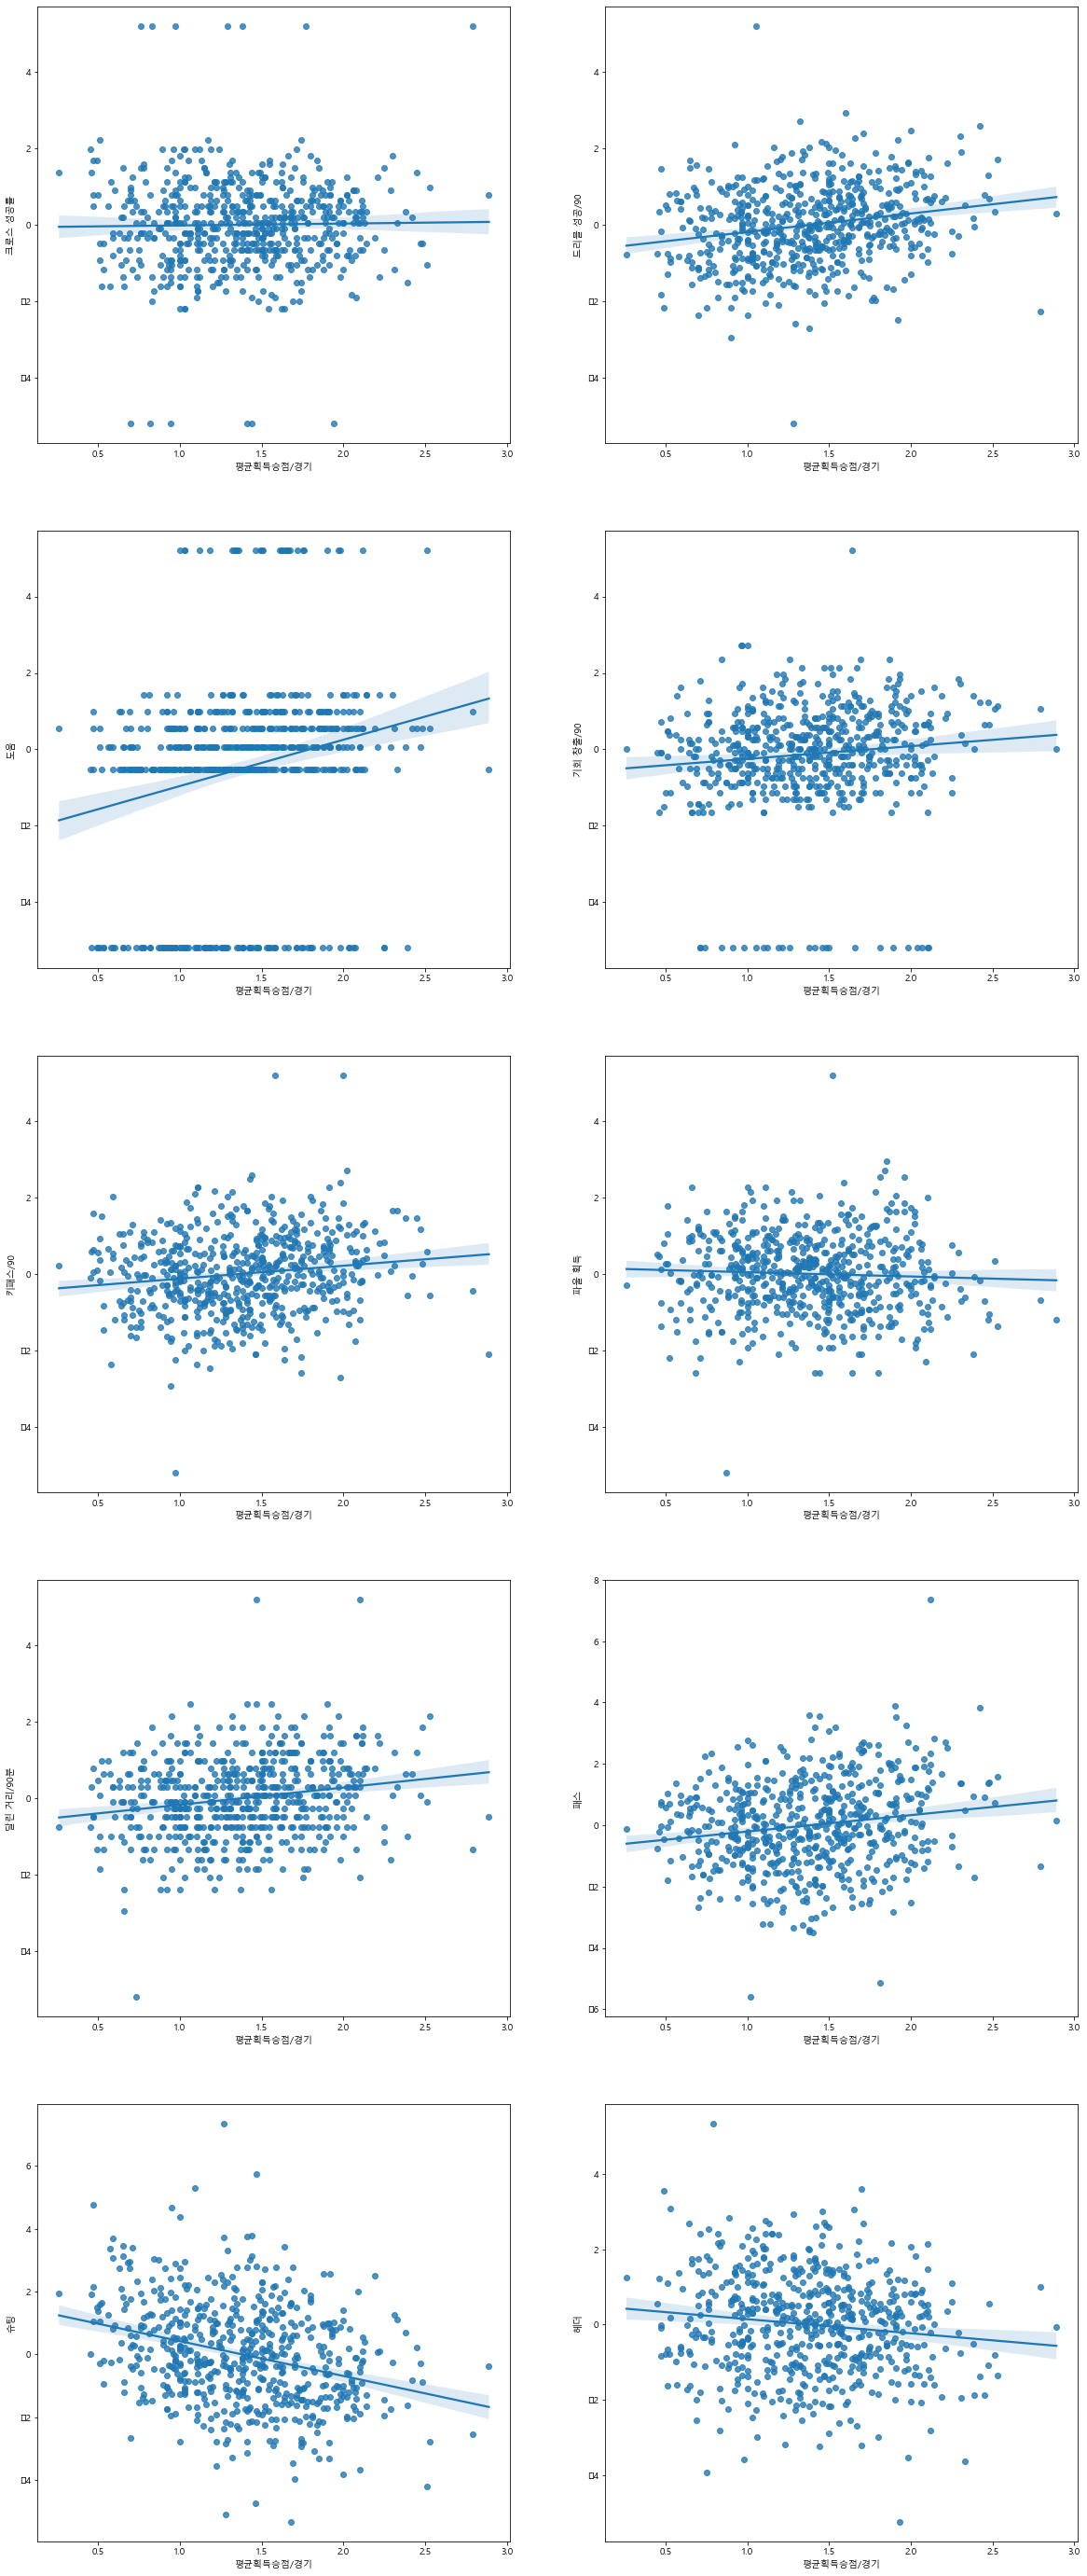

In [185]:
fig , axes = plt.subplots(5,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),good_features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [188]:

corr = [np.corrcoef(x ,y=norm_forward_df.loc[:,target].T.values)[0][1] for x in norm_forward_df.loc[:,good_features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('경기당 패스 시도/90', 0.2162421801526312),
 ('골', 0.2084347973320905),
 ('크로스 시도/90', 0.1924734201349051),
 ('공중볼시도/90', 0.16475789626511964),
 ('경기당 슈팅/90', 0.1437182767540147),
 ('경기당 유효 슈팅/90', 0.10646795991648256),
 ('크로스 성공률', 0.018038783884189447),
 ('키패스/90', -0.0483637422244552),
 ('인터셉트/90', -0.12495663946252221),
 ('태클 성공/90', -0.3017240255639746)]

### 변수 정규화

### 상관계수와 시각화를 통한 변수 선택

In [67]:
feature_comb = list(combinations(features,2))

In [68]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)\n'

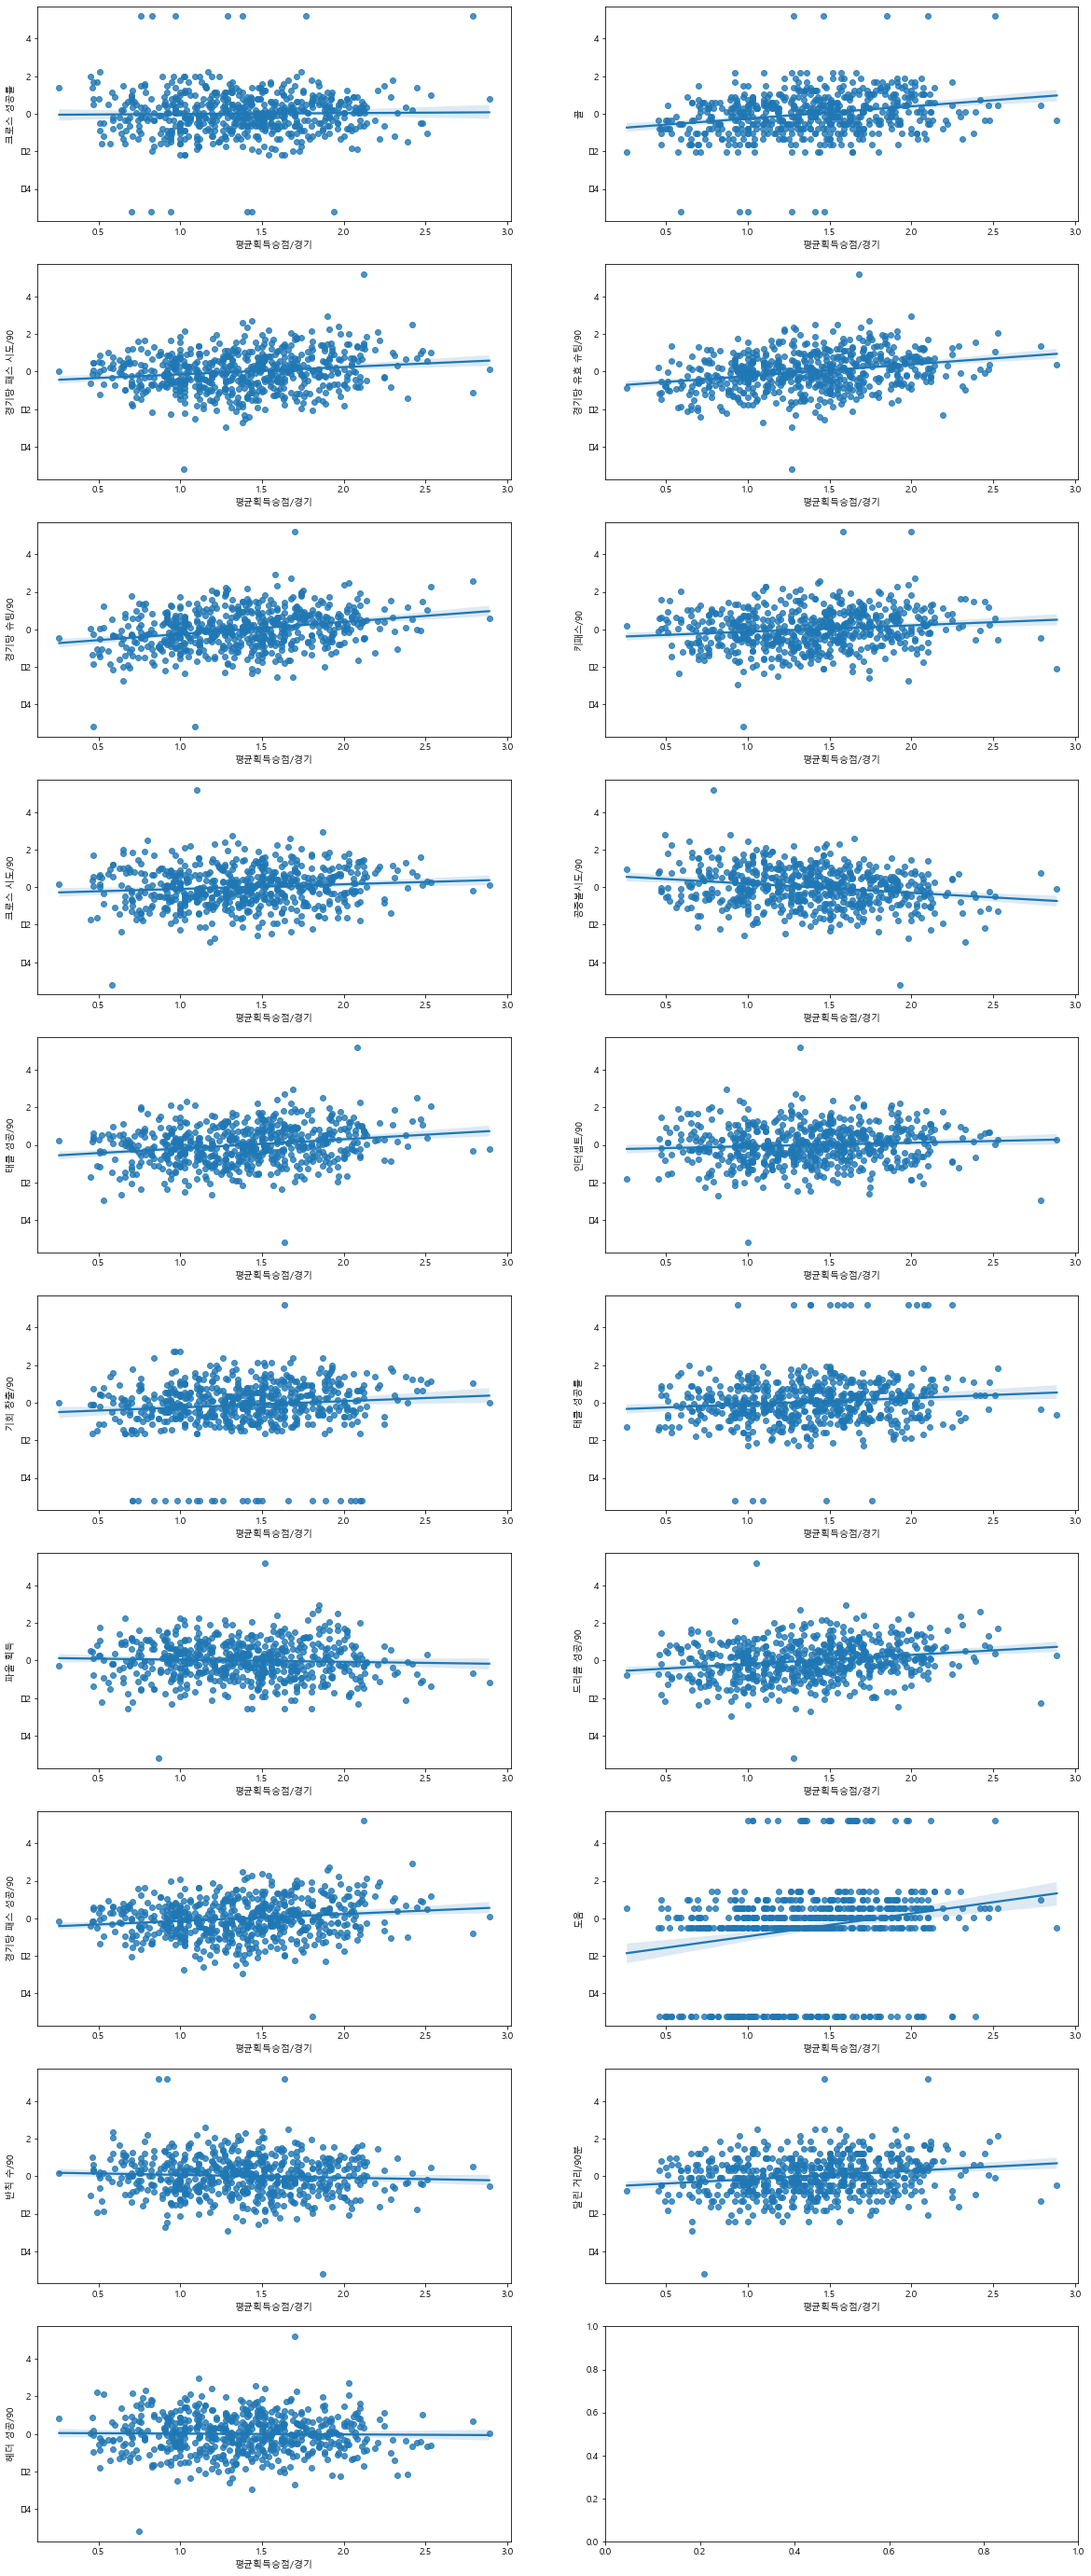

In [69]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [189]:
sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('태클 성공/90', -0.3017240255639746),
 ('경기당 패스 시도/90', 0.2162421801526312),
 ('골', 0.2084347973320905),
 ('크로스 시도/90', 0.1924734201349051),
 ('공중볼시도/90', 0.16475789626511964),
 ('경기당 슈팅/90', 0.1437182767540147),
 ('인터셉트/90', -0.12495663946252221),
 ('경기당 유효 슈팅/90', 0.10646795991648256),
 ('키패스/90', -0.0483637422244552),
 ('크로스 성공률', 0.018038783884189447)]

In [190]:
# 상관계수가 높은 변수

# 전진선택법을 위한 변수의 우선순위 순 


good_feature_order = [x[0] for x in sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)]

checkpoint_filepath = './tmp/'

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_feature_order[:i]],norm_forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(64,activation='relu')(inputs_layer)
    hidden2 = Dense(32,activation='relu')(hidden1)
    hidden3 = Dense(16,activation='relu')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=70,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)

['태클 성공/90']
Epoch 1/50
7/7 [==============================] - 0s 24ms/step - loss: 2.1331 - val_loss: 1.9180
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 1.8631 - val_loss: 1.6768
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 1.6379 - val_loss: 1.4028
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 1.3618 - val_loss: 1.0988
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 1.0570 - val_loss: 0.8155
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.7579 - val_loss: 0.6062
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.5161 - val_loss: 0.5621
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.4173 - val_loss: 0.6432
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4012 - val_loss: 0.6203
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3545 - val_loss: 0.4760
Epoch 11/50
7/7 [========

KeyError: "['경기당 패스 시도/90'] not in index"

In [22]:
forward_mae

[0.3455372901877971,
 0.34526783492830054,
 0.3434952895809906,
 0.3063080214731621,
 0.2887439814601282,
 0.27602247605420127,
 0.2723391324221486,
 0.30627155102864656]

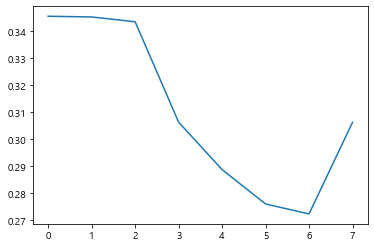

In [23]:
plt.plot(forward_mae)
plt.show()

In [24]:
good_features = good_feature_order[0:np.argmin(np.array(forward_mae))+1]
#good_features.append(good_feature_order[6])
good_features

['골',
 '도움',
 '경기당 유효 슈팅/90',
 '공중볼시도/90',
 '경기당 패스 시도/90',
 '기회 창출/90',
 '드리블 성공/90']

In [186]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_features],norm_forward_df.loc[:,target],test_size=0.2)

In [187]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(256,activation='swish')(inputs_layer)
hidden2 = Dense(512,activation='swish')(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(1024,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(2048,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dropout(0.1)(hidden5)
hidden7 = Dense(1024,activation='swish')(hidden6)
hidden8 = Dense(512,activation='swish')(hidden7)
hidden9 = Dense(256,activation='swish')(hidden8)
hidden10 = Dense(128,activation='swish')(hidden9)
hidden11 = Dense(4,activation='swish')(hidden10)
output = Dense(1,activation='linear')(hidden11)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=70,epochs=600,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
#model.save('./models/forward_nn.h5')

Epoch 1/600
7/7 [==============================] - 5s 58ms/step - loss: 20.5209 - val_loss: 17.4322
Epoch 2/600
7/7 [==============================] - 0s 25ms/step - loss: 15.8727 - val_loss: 14.1415
Epoch 3/600
7/7 [==============================] - 0s 16ms/step - loss: 12.8607 - val_loss: 11.4012
Epoch 4/600
7/7 [==============================] - 0s 16ms/step - loss: 10.4672 - val_loss: 9.2542
Epoch 5/600
7/7 [==============================] - 0s 16ms/step - loss: 8.4683 - val_loss: 7.4448
Epoch 6/600
7/7 [==============================] - 0s 16ms/step - loss: 6.8057 - val_loss: 5.9563
Epoch 7/600
7/7 [==============================] - 0s 16ms/step - loss: 5.4413 - val_loss: 4.7563
Epoch 8/600
7/7 [==============================] - 0s 16ms/step - loss: 4.3383 - val_loss: 3.7825
Epoch 9/600
7/7 [==============================] - 0s 16ms/step - loss: 3.4504 - val_loss: 3.0047
Epoch 10/600
7/7 [==============================] - 0s 16ms/step - loss: 2.7479 - val_loss: 2.3915
Epoch 11/600

Epoch 84/600
7/7 [==============================] - 0s 17ms/step - loss: 0.1271 - val_loss: 0.1402
Epoch 85/600
7/7 [==============================] - 0s 17ms/step - loss: 0.1255 - val_loss: 0.1292
Epoch 86/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1248 - val_loss: 0.1381
Epoch 87/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1260 - val_loss: 0.1473
Epoch 88/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1312 - val_loss: 0.1353
Epoch 89/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1270 - val_loss: 0.1342
Epoch 90/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1285 - val_loss: 0.1346
Epoch 91/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1261 - val_loss: 0.1316
Epoch 92/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1255 - val_loss: 0.1357
Epoch 93/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1289 - val_loss: 0.1422
Epoch 94/6

7/7 [==============================] - 0s 16ms/step - loss: 0.1127 - val_loss: 0.1271
Epoch 167/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1147 - val_loss: 0.1292
Epoch 168/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1143 - val_loss: 0.1297
Epoch 169/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1122 - val_loss: 0.1281
Epoch 170/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1175 - val_loss: 0.1315
Epoch 171/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1112 - val_loss: 0.1279
Epoch 172/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1158 - val_loss: 0.1337
Epoch 173/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1169 - val_loss: 0.1270
Epoch 174/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1107 - val_loss: 0.1255
Epoch 175/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1077 - val_loss: 0.1285
Epoch 176/600


7/7 [==============================] - 0s 16ms/step - loss: 0.1045 - val_loss: 0.1305
Epoch 249/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1037 - val_loss: 0.1310
Epoch 250/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1026 - val_loss: 0.1308
Epoch 251/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1026 - val_loss: 0.1354
Epoch 252/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1023 - val_loss: 0.1330
Epoch 253/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1008 - val_loss: 0.1345
Epoch 254/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1011 - val_loss: 0.1369
Epoch 255/600
7/7 [==============================] - 0s 15ms/step - loss: 0.1021 - val_loss: 0.1407
Epoch 256/600
7/7 [==============================] - 0s 16ms/step - loss: 0.1055 - val_loss: 0.1393
Epoch 257/600
7/7 [==============================] - 0s 17ms/step - loss: 0.1047 - val_loss: 0.1396
Epoch 258/600


7/7 [==============================] - 0s 17ms/step - loss: 0.0921 - val_loss: 0.1425
Epoch 331/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0940 - val_loss: 0.1395
Epoch 332/600
7/7 [==============================] - 0s 19ms/step - loss: 0.0912 - val_loss: 0.1471
Epoch 333/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0927 - val_loss: 0.1433
Epoch 334/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0958 - val_loss: 0.1439
Epoch 335/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0962 - val_loss: 0.1459
Epoch 336/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0951 - val_loss: 0.1370
Epoch 337/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0966 - val_loss: 0.1447
Epoch 338/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0942 - val_loss: 0.1474
Epoch 339/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0931 - val_loss: 0.1573
Epoch 340/600


7/7 [==============================] - 0s 15ms/step - loss: 0.0874 - val_loss: 0.1494
Epoch 413/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0859 - val_loss: 0.1478
Epoch 414/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0861 - val_loss: 0.1496
Epoch 415/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0900 - val_loss: 0.1465
Epoch 416/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0845 - val_loss: 0.1487
Epoch 417/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0873 - val_loss: 0.1457
Epoch 418/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0844 - val_loss: 0.1493
Epoch 419/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0856 - val_loss: 0.1544
Epoch 420/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0844 - val_loss: 0.1481
Epoch 421/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0815 - val_loss: 0.1480
Epoch 422/600


7/7 [==============================] - 0s 16ms/step - loss: 0.0810 - val_loss: 0.1457
Epoch 495/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0799 - val_loss: 0.1544
Epoch 496/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0802 - val_loss: 0.1521
Epoch 497/600
7/7 [==============================] - 0s 14ms/step - loss: 0.0750 - val_loss: 0.1572
Epoch 498/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0803 - val_loss: 0.1530
Epoch 499/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0786 - val_loss: 0.1639
Epoch 500/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0829 - val_loss: 0.1539
Epoch 501/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0772 - val_loss: 0.1548
Epoch 502/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0785 - val_loss: 0.1647
Epoch 503/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0831 - val_loss: 0.1526
Epoch 504/600


7/7 [==============================] - 0s 16ms/step - loss: 0.0698 - val_loss: 0.1711
Epoch 577/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0783 - val_loss: 0.1635
Epoch 578/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0688 - val_loss: 0.1547
Epoch 579/600
7/7 [==============================] - 0s 16ms/step - loss: 0.0674 - val_loss: 0.1604
Epoch 580/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0748 - val_loss: 0.1622
Epoch 581/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0704 - val_loss: 0.1711
Epoch 582/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0714 - val_loss: 0.1655
Epoch 583/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0709 - val_loss: 0.1607
Epoch 584/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0682 - val_loss: 0.1636
Epoch 585/600
7/7 [==============================] - 0s 15ms/step - loss: 0.0696 - val_loss: 0.1576
Epoch 586/600


In [27]:
model = load_model('./models/forward_nn.h5')

In [28]:
norm_forward_df['predict'] = model.predict(norm_forward_df.loc[:,['골','도움','경기당 유효 슈팅/90','공중볼시도/90','경기당 패스 시도/90','기회 창출/90','드리블 성공/90']])

# 모델 검정

In [29]:
residual = norm_forward_df['평균획득승점/경기'] - norm_forward_df['predict']

## 모형의 선형성 검정

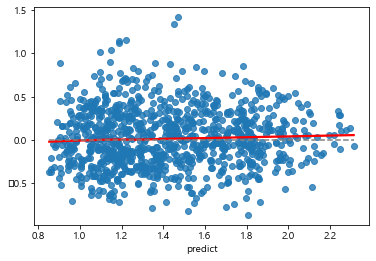

In [30]:
sns.regplot(norm_forward_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([norm_forward_df['predict'].values.min(), norm_forward_df['predict'].values.max()], [0, 0], '--', color='grey')

## 정규성 검정

In [31]:
stats.shapiro(residual)

ShapiroResult(statistic=0.9932886362075806, pvalue=0.00019335150136612356)

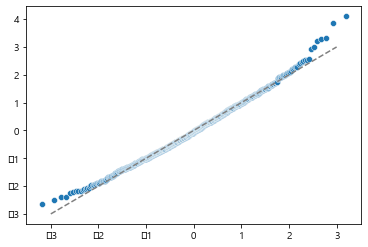

In [32]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 등분산성 검정

In [33]:
stats.levene(norm_forward_df['평균획득승점/경기'],norm_forward_df['predict'])

LeveneResult(statistic=125.92937685657498, pvalue=2.248162775426294e-28)

<AxesSubplot:>

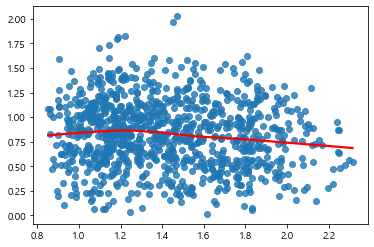

In [34]:
sns.regplot(norm_forward_df['predict'].values, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})